In [55]:
import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from matplotlib import pyplot as plt
%matplotlib inline

from agents import A2CAgent, RandomAgent, DQNAgent, PPOAgent  # noqa
from env import TrafficLightEnv
from util import ALL_LIGHTS_OFF, LEFT_LIGHT_ON, RIGHT_LIGHT_ON


In [56]:
# Init
env_params = {}
env = TrafficLightEnv(**env_params)
agent = A2CAgent(env, 50_000)
vec_env = make_vec_env(TrafficLightEnv, n_envs=1, env_kwargs=env_params, seed=123)


In [58]:
# Train
agent.train()

Agent training...


In [62]:
# Reset
obs = vec_env.reset()

In [64]:
# Run
print("---------------------------")
print("Step #0")
vec_env.render()
print()

max_steps = 2000
cars = []
actions = []
for step in range(max_steps):
    print(f"Step #{step + 1}")

    # Get action
    action = agent.get_action(obs)  # type: ignore
    actions.append(action[0])
    print("Action:", action)

    # Get env response
    obs, reward, done, info = vec_env.step(action)
    cars.append((obs[0][1], obs[0][3]))

    # Check if done
    if done:
        print(f"Response: done={done}, info={info}")
        print("Goal reached!")
        break

    # Print
    print(f"Response: obs={obs}, reward={reward}, done={done}, info={info}")
    print("State:  ", end="")
    vec_env.render()
    print()

---------------------------
Step #0
1 -> |    | <- 1

Step #1
Action: [1]
Response: obs=[[0. 1. 1. 1.]], reward=[1.], done=[False], info=[{'passed_left': 1, 'passed_right': 0, 'new_left': 1, 'new_right': 0, 'TimeLimit.truncated': False}]
State:  1 -> |    | <- 1

Step #2
Action: [2]
Response: obs=[[1. 1. 0. 4.]], reward=[1.], done=[False], info=[{'passed_left': 0, 'passed_right': 1, 'new_left': 0, 'new_right': 4, 'TimeLimit.truncated': False}]
State:  1 -> |    | <- 4

Step #3
Action: [2]
Response: obs=[[2. 2. 0. 1.]], reward=[3.], done=[False], info=[{'passed_left': 0, 'passed_right': 4, 'new_left': 1, 'new_right': 1, 'TimeLimit.truncated': False}]
State:  2 -> |    | <- 1

Step #4
Action: [1]
Response: obs=[[0. 2. 1. 3.]], reward=[2.], done=[False], info=[{'passed_left': 2, 'passed_right': 0, 'new_left': 2, 'new_right': 2, 'TimeLimit.truncated': False}]
State:  2 -> |    | <- 3

Step #5
Action: [2]
Response: obs=[[2. 3. 0. 0.]], reward=[3.], done=[False], info=[{'passed_left': 0, 'pa

In [65]:
# Format plot data
if done:
    cars.append((0, 0))

cars_left, cars_right = map(list, zip(*cars))
max_cars = max(cars_left + cars_right)

total_cars = [cl + cr for cl, cr in cars]
cars_left = [-c for c in cars_left]
ACTION_MAP = {ALL_LIGHTS_OFF: 0, LEFT_LIGHT_ON: -max_cars -1, RIGHT_LIGHT_ON: max_cars + 1}
actions = [ACTION_MAP[a] for a in actions]

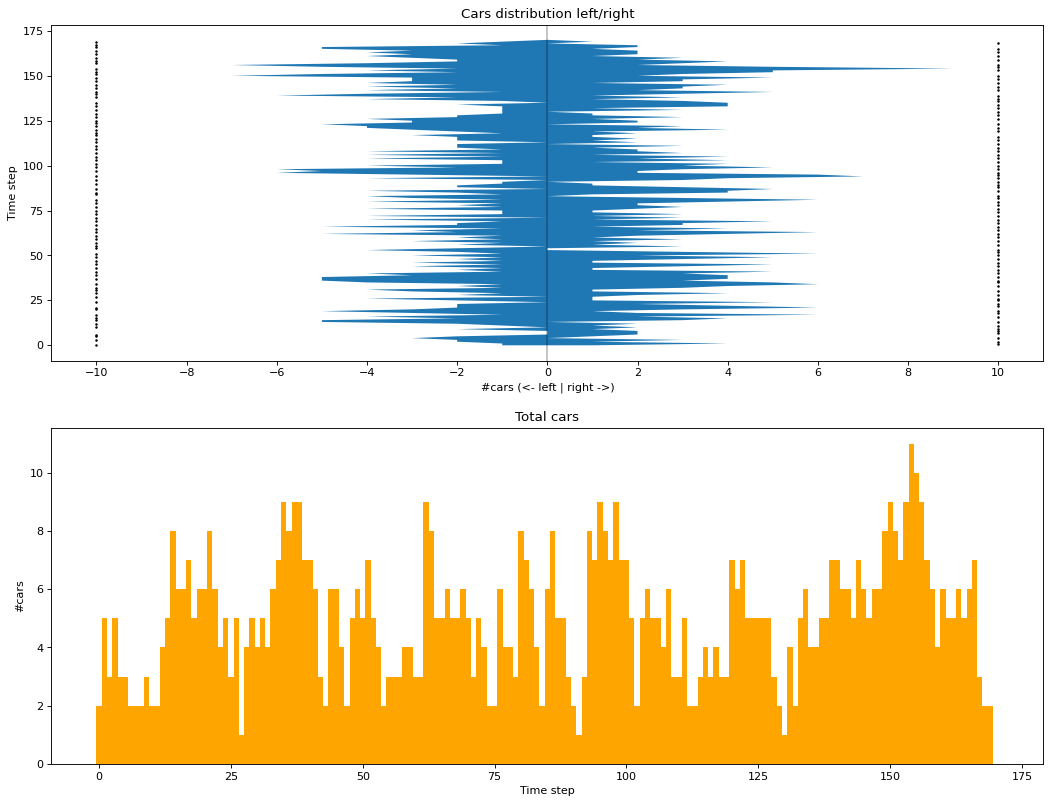

In [66]:
# Plot
figure, axis = plt.subplots(2, figsize=(16, 12), dpi=80)


axis[0].fill_betweenx(list(range(len(cars))), cars_left, cars_right) 
axis[0].scatter(actions, list(range(len(actions))), s=1.5, c="black")  # action taken
axis[0].axvline(0, c="black", linewidth=0.4)

ticks = range(int(-max_cars * 1.2), int(max_cars * 1.2) + 1, int(max_cars * 2.4) // 8)
axis[0].set_xticks(ticks)
axis[0].set_title("Cars distribution left/right")
axis[0].set_ylabel("Time step")
axis[0].set_xlabel("#cars (<- left | right ->)")


axis[1].set_title("Total cars")
axis[1].set_xlabel("Time step")
axis[1].set_ylabel("#cars")
axis[1].bar(list(range(len(total_cars))), total_cars, width=1.0, color="orange")

plt.show()